In [1]:
# all imports
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import StandardScaler
import os
import time

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor,Resize,ColorJitter,CenterCrop,Grayscale
import torchvision.models as models

from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

In [2]:
# defining functions

# reads xml-data
def read_data(file):
    with open(file, 'r') as f:
        data = f.read()
    bs_data = bs(data, 'xml') 
    return bs_data


# gets the bname for calculations
def get_bname(path):
    for xml_file in os.listdir(path):
        if xml_file.startswith("timeseries"):
            bs_data = read_data(path + xml_file)
            b_name = bs_data.find_all('name')
            return b_name    


# returns a dataframe given some data
def values_df(bs_data, low, high):
    b_name = bs_data.find_all('name')
    attributes = []
    # finds all values 
    for i in range(len(b_name)):
        attributes.append(b_name[i].get('value'))

    attributes = list(attributes)
    collection = {}
    
    # finds x-, y- and z-values and computes euclidian distance
    for i in range(low, high):
        r = calc(b_name, i)
        collection[attributes[i]] = r

    df = pd.DataFrame(collection)
    return df


# calculates the euclidian values
def calc(b_name, i):
    a1 = b_name[i].find_all('component')[0].get('data')
    b1 = b_name[i].find_all('component')[1].get('data')
    c1 = b_name[i].find_all('component')[2].get('data')
    x = np.asarray([float(x) for x in a1.split(',')])
    y = np.asarray([float(y) for y in b1.split(',')])
    z = np.asarray([float(z) for z in c1.split(',')])
    r = (x**2 + y**2 + z**2)**0.5
    return r


# calculates difference between max and min 
def get_differences_values(path, low, high):
    i = 0
    diff_list = []
    
    for xml_file in os.listdir(path):
        if xml_file.startswith("timeseries"):
            try:
                bs_data = read_data(path + xml_file)
                b_name = bs_data.find_all('name')
                
                # fix since these values for some reason don't work when passed as arguments
                if low >= 3*int(len(b_name)/4):
                    low = 3*int(len(b_name)/4)
                    high = int(len(b_name))
                    
                df1 = values_df(bs_data, low, high)

                df_max = pd.DataFrame(df1.max().to_dict(),index=[df1.index.values[-1]])
                df_min = pd.DataFrame(df1.min().to_dict(),index=[df1.index.values[-1]])
                df1 = df_max.subtract(df_min, fill_value=0)
                df1 = df1.rename(index={100:i})

                diff_list.append(df1)
                i+=1
            except:
                 print(xml_file + " failed to compute")
        else:
            continue
            
    if "healthy" in path.lower():
        injurylevel = [0 for i in range(len(diff_list))]
    else: 
        injurylevel = [1 for i in range(len(diff_list))]
    data_level1 = pd.concat(diff_list)
    data_level1['Injury level'] = injurylevel
    print(f"Length of how many timeseries-files of {path} people we have between files {low} and {high}: {i}")

    return data_level1


# gets accuracy of the algorithms

def get_accuracy(algorithm, data, test_size):
    if algorithm == KNeighborsClassifier:
        classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    elif algorithm == RandomForestClassifier:
        classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    else:
        classifier = algorithm()
    y = data['Injury level']
    y = pd.DataFrame(y, columns = ['Injury level'])
    X = data.drop(['Injury level'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    my_imputer = SimpleImputer()
    imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
    imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

    imputed_X_train.columns = X_train.columns
    imputed_X_test.columns = X_test.columns

    sc = StandardScaler()
    X_train = sc.fit_transform(imputed_X_train)
    X_test = sc.transform(imputed_X_test)
    
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

# creating custom datasets

class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
def get_attributes():
    # get the attributes
    path = "USE THIS/PFPS/"
    xml_file = 'timeseries-11.xml'
    bs_data = read_data(path+xml_file)
    b_name = bs_data.find_all('name')

    attributes = []
    for i in range(len(b_name)):
        attributes.append(b_name[i].get('value'))

    attributes = list(set(attributes))
    return attributes
    

# returns probability of a person having PFPS
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    if y_pred_tag == y_test:
        return True
    else:
        return False

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features = 32, out_features = 16)
        self.fc2 = nn.Linear(in_features = 16, out_features = 8)
        self.out = nn.Linear(in_features = 8, out_features = 1)
        
    def forward(self, t):
        t = t
        
        t = self.fc1(t)
        t = F.relu(t)
        
        t = self.fc2(t)
        t = F.relu(t)
        
        t = self.out(t)
        
        return t


## Preprocessing the data

Calculating the differences between the max and min-values in each attribute for each person in the four power levels.

In [5]:
# calculate the four power levels for healthy people:

path = "USE THIS/Healthy/"

b_name = get_bname(path)

diff_list1 = get_differences_values(path, 0, int(len(b_name)/4))
diff_list2 = get_differences_values(path, int(len(b_name)/4), int(len(b_name)/2))
diff_list3 = get_differences_values(path, int(len(b_name)/2), int(3*len(b_name)/4))
diff_list4 = get_differences_values(path, int(3*len(b_name)/4), int(len(b_name)))


# calculate the four power levels for injured people:

path = "USE THIS/PFPS/"

diff_list_injured1 = get_differences_values(path, 0, int(len(b_name)/4))
diff_list_injured2 = get_differences_values(path, int(len(b_name)/4), int(len(b_name)/2))
diff_list_injured3 = get_differences_values(path, int(len(b_name)/2), int(3*len(b_name)/4))
diff_list_injured4 = get_differences_values(path, int(3*len(b_name)/4), len(b_name))


# combine the data into the same dataframes

df_healthy = pd.concat([diff_list1, diff_list2, diff_list3, diff_list4])
df_pfps = pd.concat([diff_list_injured1, diff_list_injured2, diff_list_injured3, diff_list_injured4])
df_combined = pd.concat([df_healthy, df_pfps])

data3_level1 = pd.concat([diff_list1, diff_list_injured1]).reset_index(drop = True)
data3_level2 = pd.concat([diff_list2, diff_list_injured2]).reset_index(drop = True)
data3_level3 = pd.concat([diff_list3, diff_list_injured3]).reset_index(drop = True)
data3_level4 = pd.concat([diff_list4, diff_list_injured4]).reset_index(drop = True)


timeseries-10.xml failed to compute
timeseries-44.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 0 and 33: 21
timeseries-10.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 33 and 66: 22
timeseries-10.xml failed to compute
timeseries-23.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 66 and 99: 21
timeseries-10.xml failed to compute
timeseries-23.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 93 and 126: 21
Length of how many timeseries-files of USE THIS/PFPS/ people we have between files 0 and 33: 20
Length of how many timeseries-files of USE THIS/PFPS/ people we have between files 33 and 66: 20
Length of how many timeseries-files of USE THIS/PFPS/ people we have between files 66 and 99: 20
Length of how many timeseries-files of USE THIS/PFPS/ peop

## Preprocessing the data

Dividing the data into training and test data. 

In [8]:
def get_ml_data(df_healthy, df_pfps):

    y = df_combined['Injury level']
    y = pd.DataFrame(y, columns = ['Injury level'])
    X = df_combined.drop(['Injury level'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    return X, X_test, X_train, y_test, y_train

In [9]:
X, X_test, X_train, y_test, y_train = get_ml_data(df_healthy, df_pfps)

X1, X_test1, X_train1, y_test1, y_train1 = get_ml_data(diff_list1, diff_list_injured1)
X2, X_test2, X_train2, y_test2, y_train2 = get_ml_data(diff_list2, diff_list_injured2)
X3, X_test3, X_train3, y_test3, y_train3 = get_ml_data(diff_list3, diff_list_injured3)
X4, X_test4, X_train4, y_test4, y_train4 = get_ml_data(diff_list4, diff_list_injured4)


def get_X_data(X_test, X_train):
    

    my_imputer = SimpleImputer()
    imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
    imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

    imputed_X_train.columns = X_train.columns
    imputed_X_test.columns = X_test.columns

    sc = StandardScaler()
    X_train = sc.fit_transform(imputed_X_train)
    X_test = sc.transform(imputed_X_test)
    
    return X_train, X_test

X_train, X_test = get_X_data(X_test, X_train)

X_train1, X_test1 = get_X_data(X_test1, X_train1)
X_train2, X_test2 = get_X_data(X_test2, X_train2)
X_train3, X_test3 = get_X_data(X_test3, X_train3)
X_train4, X_test4 = get_X_data(X_test4, X_train4)

## Logistic regression

Calculates the confusion matrix, accuracy score and cross-validation scores using scikit-learn.

For further documentation please see [scikit-learn documentation](https://scikit-learn.org/stable/)

The confusion matrix at level 0 is: 
 [[12  4]
 [ 2 15]]
The accuracy score is: 0.8181818181818182
The cross validation scores for logistic regression at level 0 are [0.7037037  0.85185185 0.84615385 0.84615385 0.88461538]
The mean of the cross validation scores for logistic regression is: 0.8412087912087912


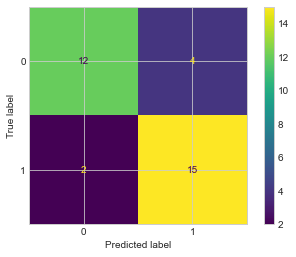

The confusion matrix at level 1 is: 
 [[16  0]
 [ 2 15]]
The accuracy score is: 0.9393939393939394
The cross validation scores for logistic regression at level 1 are [0.88888889 0.81481481 0.84615385 0.76923077 0.84615385]
The mean of the cross validation scores for logistic regression is: 0.8412087912087912


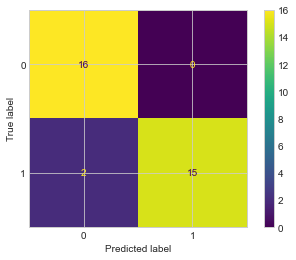

The confusion matrix at level 2 is: 
 [[13  4]
 [ 3 13]]
The accuracy score is: 0.7878787878787878
The cross validation scores for logistic regression at level 2 are [0.81481481 0.88888889 0.73076923 0.88461538 0.73076923]
The mean of the cross validation scores for logistic regression is: 0.8483516483516483


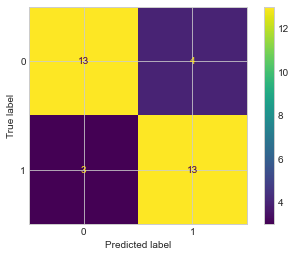

The confusion matrix at level 3 is: 
 [[17  0]
 [ 5 11]]
The accuracy score is: 0.8484848484848485
The cross validation scores for logistic regression at level 3 are [0.96296296 0.85185185 0.84615385 0.80769231 0.84615385]
The mean of the cross validation scores for logistic regression is: 0.8554945054945055


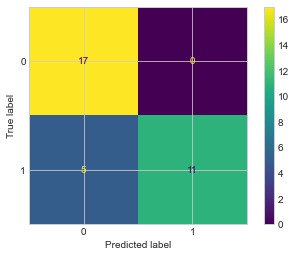

The confusion matrix at level 4 is: 
 [[18  2]
 [ 2 11]]
The accuracy score is: 0.8787878787878788
The cross validation scores for logistic regression at level 4 are [0.81481481 0.77777778 0.88461538 0.80769231 0.80769231]
The mean of the cross validation scores for logistic regression is: 0.8258241758241758


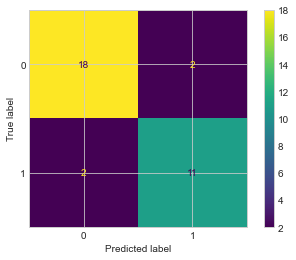

In [10]:
# Logistic Regression
def log_reg(X_test, X_train, y_train, y_test, level):
    classifier = LogisticRegression(random_state = 0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    score1 = accuracy_score(y_test, y_pred)
    print(f"The confusion matrix at level {level} is: \n {cm}")
    score2 = accuracy_score(y_test, y_pred)
    print(f"The accuracy score is: {score1}")
    scores = cross_val_score(classifier, X_train, y_train, cv=5)

    print(f"The cross validation scores for logistic regression at level {level} are {scores}")

    print(f"The mean of the cross validation scores for logistic regression is: {np.mean(cross_val_score(classifier, X_train, y_train, cv=10))}")

    y_pred = classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

data_list = [(X_test, X_train, y_train, y_test, 0), (X_test1, X_train1, y_train1, y_test1, 1), (X_test2, X_train2, y_train2, y_test2, 2), (X_test3, X_train3, y_train3, y_test3, 3), (X_test4, X_train4, y_train4, y_test4, 4)]
for (X_test, X_train, y_train, y_test, level) in data_list:
    log_reg(X_test, X_train, y_train, y_test, level)

## Random Forest

The confusion matrix at level 0 is: 
 [[15  1]
 [ 3 14]]
The accuracy score is: 0.8787878787878788
The cross validation scores for random forest are [0.66666667 0.74074074 0.80769231 0.73076923 0.76923077]
The mean of the cross validation scores for random forest is: 0.7725274725274726


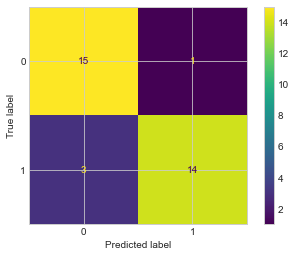

The confusion matrix at level 1 is: 
 [[16  0]
 [ 2 15]]
The accuracy score is: 0.9393939393939394
The cross validation scores for random forest are [0.85185185 0.55555556 0.73076923 0.65384615 0.73076923]
The mean of the cross validation scores for random forest is: 0.765934065934066


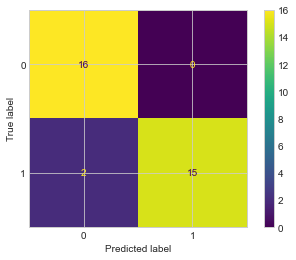

The confusion matrix at level 2 is: 
 [[16  1]
 [ 3 13]]
The accuracy score is: 0.8787878787878788
The cross validation scores for random forest are [0.85185185 0.81481481 0.73076923 0.84615385 0.69230769]
The mean of the cross validation scores for random forest is: 0.7785714285714286


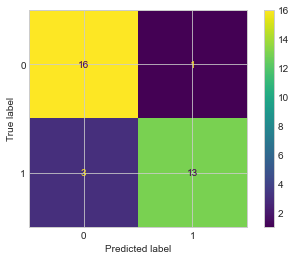

The confusion matrix at level 3 is: 
 [[17  0]
 [ 7  9]]
The accuracy score is: 0.7878787878787878
The cross validation scores for random forest are [0.88888889 0.81481481 0.76923077 0.65384615 0.73076923]
The mean of the cross validation scores for random forest is: 0.7956043956043957


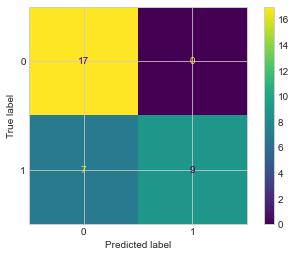

The confusion matrix at level 4 is: 
 [[16  4]
 [ 1 12]]
The accuracy score is: 0.8484848484848485
The cross validation scores for random forest are [0.77777778 0.55555556 0.65384615 0.76923077 0.69230769]
The mean of the cross validation scores for random forest is: 0.7659340659340661


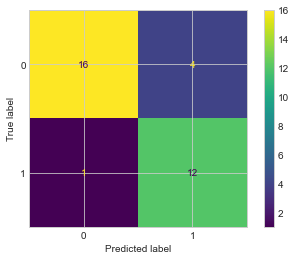

In [11]:
# Random Forest
def forest(X_test, X_train, y_train, y_test, level):
    forest_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    forest_classifier.fit(X_train, y_train)
    y_pred = forest_classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"The confusion matrix at level {level} is: \n {cm}")
    score2 = accuracy_score(y_test, y_pred)
    print(f"The accuracy score is: {score2}")
    scores = cross_val_score(forest_classifier, X_train, y_train, cv=5)

    print(f"The cross validation scores for random forest are {scores}")

    print(f"The mean of the cross validation scores for random forest is: {np.mean(cross_val_score(forest_classifier, X_train, y_train, cv=10))}")

    y_pred = forest_classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()


for (X_test, X_train, y_train, y_test, level) in data_list:
    forest_classifier = forest(X_test, X_train, y_train, y_test, level)

## Naive Bayes

The confusion matrix at level 0 is: 
 [[12  4]
 [ 0 17]]
The accuracy score is: 0.8787878787878788
The cross validation scores for naive bayes are [0.59259259 0.37037037 0.65384615 0.65384615 0.46153846]
The mean of the cross validation scores for naive bayes is 0.5901098901098901


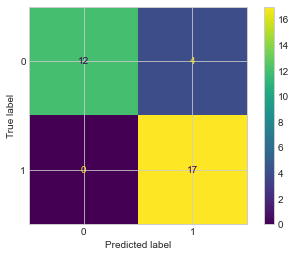

The confusion matrix at level 1 is: 
 [[ 5 11]
 [ 3 14]]
The accuracy score is: 0.5757575757575758
The cross validation scores for naive bayes are [0.59259259 0.66666667 0.61538462 0.5        0.76923077]
The mean of the cross validation scores for naive bayes is 0.6285714285714286


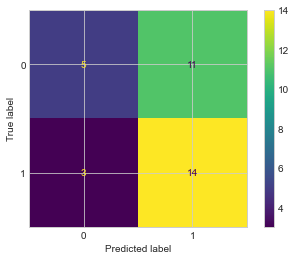

The confusion matrix at level 2 is: 
 [[ 9  8]
 [ 5 11]]
The accuracy score is: 0.6060606060606061
The cross validation scores for naive bayes are [0.77777778 0.66666667 0.69230769 0.73076923 0.61538462]
The mean of the cross validation scores for naive bayes is 0.6956043956043956


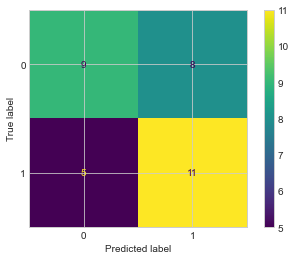

The confusion matrix at level 3 is: 
 [[15  2]
 [ 8  8]]
The accuracy score is: 0.696969696969697
The cross validation scores for naive bayes are [0.74074074 0.55555556 0.80769231 0.76923077 0.61538462]
The mean of the cross validation scores for naive bayes is 0.689010989010989


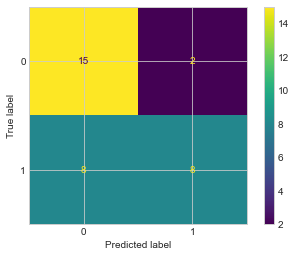

The confusion matrix at level 4 is: 
 [[12  8]
 [ 1 12]]
The accuracy score is: 0.7272727272727273
The cross validation scores for naive bayes are [0.59259259 0.51851852 0.65384615 0.65384615 0.76923077]
The mean of the cross validation scores for naive bayes is 0.6593406593406594


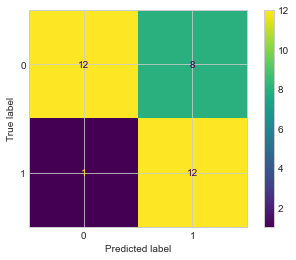

In [12]:
#Naive Bayes
def naive(X_test, X_train, y_train, y_test, level):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train, y_train)
    y_pred = naive_classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    print(f"The confusion matrix at level {level} is: \n {cm}")
    score3 = accuracy_score(y_test, y_pred)
    print(f"The accuracy score is: {score3}")

    scores = cross_val_score(naive_classifier, X_train, y_train, cv=5)
    print(f"The cross validation scores for naive bayes are {scores}")

    print(f"The mean of the cross validation scores for naive bayes is {np.mean(cross_val_score(naive_classifier, X_train, y_train, cv=10))}")

    y_pred = naive_classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    
for (X_test, X_train, y_train, y_test, level) in data_list:
    naive(X_test, X_train, y_train, y_test, level)

## K-nearest neighbour (KNC) 

The confusion matrix at level 0 is: 
 [[10  6]
 [ 8  9]]
The accuracy score is: 0.5757575757575758
The cross validation scores for KNC are [0.51851852 0.77777778 0.65384615 0.61538462 0.61538462]
The mean of the cross validation scores for KNC is 0.6604395604395605


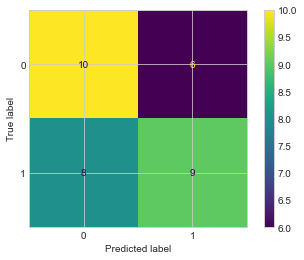

The confusion matrix at level 1 is: 
 [[12  4]
 [ 3 14]]
The accuracy score is: 0.7878787878787878
The cross validation scores for KNC are [0.51851852 0.55555556 0.61538462 0.53846154 0.65384615]
The mean of the cross validation scores for KNC is 0.5928571428571429


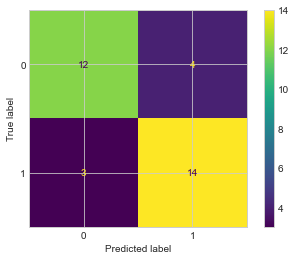

The confusion matrix at level 2 is: 
 [[14  3]
 [ 5 11]]
The accuracy score is: 0.7575757575757576
The cross validation scores for KNC are [0.40740741 0.62962963 0.61538462 0.69230769 0.57692308]
The mean of the cross validation scores for KNC is 0.6313186813186813


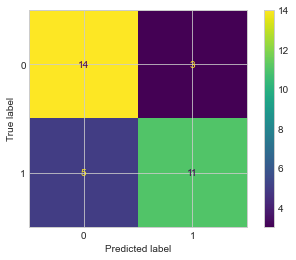

The confusion matrix at level 3 is: 
 [[14  3]
 [ 6 10]]
The accuracy score is: 0.7272727272727273
The cross validation scores for KNC are [0.66666667 0.66666667 0.65384615 0.53846154 0.65384615]
The mean of the cross validation scores for KNC is 0.6593406593406593


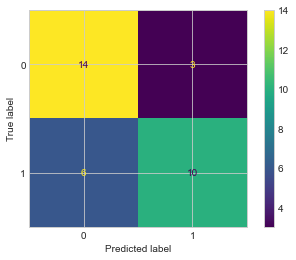

The confusion matrix at level 4 is: 
 [[12  8]
 [ 4  9]]
The accuracy score is: 0.6363636363636364
The cross validation scores for KNC are [0.74074074 0.7037037  0.61538462 0.69230769 0.65384615]
The mean of the cross validation scores for KNC is 0.718131868131868


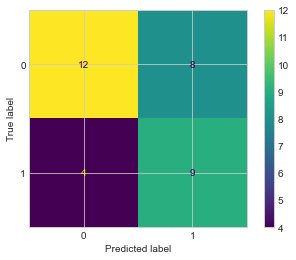

In [13]:
#KNC
def knc(X_test, X_train, y_train, y_test, level):
    KNC_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    KNC_classifier.fit(X_train, y_train)
    y_pred = KNC_classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    print(f"The confusion matrix at level {level} is: \n {cm}")
    score4 = accuracy_score(y_test, y_pred)
    print(f"The accuracy score is: {score4}")

    scores = cross_val_score(KNC_classifier, X_train, y_train, cv=5)
    print(f"The cross validation scores for KNC are {scores}")

    print(f"The mean of the cross validation scores for KNC is {np.mean(cross_val_score(KNC_classifier, X_train, y_train, cv=10))}")

    y_pred = KNC_classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    
for (X_test, X_train, y_train, y_test, level) in data_list:
    knc(X_test, X_train, y_train, y_test, level)

## Linear support vector classification (SVC)

The confusion matrix at level 0 is: 
 [[13  3]
 [ 3 14]]
The accuracy score is: 0.8181818181818182
The cross validation scores for SVC are [0.81481481 0.88888889 0.84615385 0.73076923 0.88461538]
The mean of the cross validation scores for SVC is 0.8406593406593406


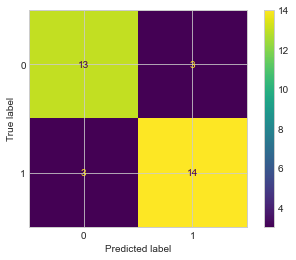

The confusion matrix at level 1 is: 
 [[15  1]
 [ 2 15]]
The accuracy score is: 0.9090909090909091
The cross validation scores for SVC are [0.85185185 0.85185185 0.84615385 0.76923077 0.88461538]
The mean of the cross validation scores for SVC is 0.8335164835164834


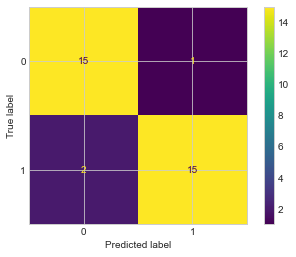

The confusion matrix at level 2 is: 
 [[12  5]
 [ 2 14]]
The accuracy score is: 0.7878787878787878
The cross validation scores for SVC are [0.77777778 0.85185185 0.76923077 0.92307692 0.73076923]
The mean of the cross validation scores for SVC is 0.8324175824175825


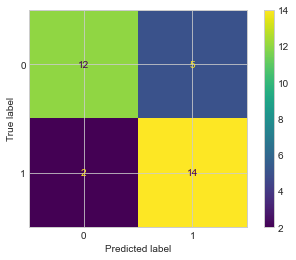

The confusion matrix at level 3 is: 
 [[17  0]
 [ 7  9]]
The accuracy score is: 0.7878787878787878
The cross validation scores for SVC are [0.92592593 0.81481481 0.80769231 0.76923077 0.80769231]
The mean of the cross validation scores for SVC is 0.8252747252747252


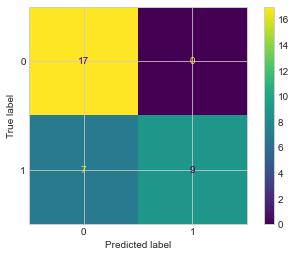

The confusion matrix at level 4 is: 
 [[19  1]
 [ 3 10]]
The accuracy score is: 0.8787878787878788
The cross validation scores for SVC are [0.88888889 0.74074074 0.88461538 0.80769231 0.80769231]
The mean of the cross validation scores for SVC is 0.7956043956043957


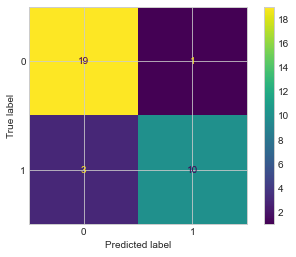

In [14]:
#SVC
def svc(X_test, X_train, y_train, y_test, level):
    SVC_classifier = SVC(kernel = 'linear', random_state = 0)
    SVC_classifier.fit(X_train, y_train)
    y_pred = SVC_classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    score5 = accuracy_score(y_test, y_pred)
    print(f"The confusion matrix at level {level} is: \n {cm}")
    print(f"The accuracy score is: {score5}")

    scores = cross_val_score(SVC_classifier, X_train, y_train, cv=5)
    print(f"The cross validation scores for SVC are {scores}")

    print(f"The mean of the cross validation scores for SVC is {np.mean(cross_val_score(SVC_classifier, X_train, y_train, cv=10))}")

    y_pred = SVC_classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    
for (X_test, X_train, y_train, y_test, level) in data_list:
    svc(X_test, X_train, y_train, y_test, level)

## XGBoost

[17:00:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The confusion matrix at level 0 is: 
 [[16  0]
 [ 2 15]]
The accuracy score is: 0.9393939393939394
[17:00:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:00:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

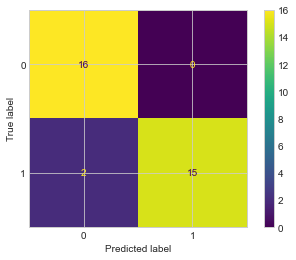

[17:01:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The confusion matrix at level 1 is: 
 [[16  0]
 [ 2 15]]
The accuracy score is: 0.9393939393939394
[17:01:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

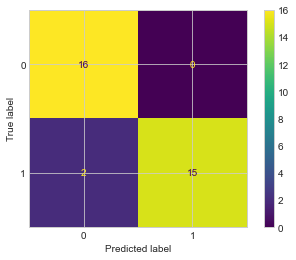

[17:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The confusion matrix at level 2 is: 
 [[16  1]
 [ 2 14]]
The accuracy score is: 0.9090909090909091
[17:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

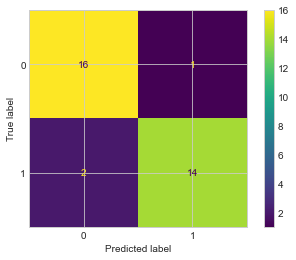

[17:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The confusion matrix at level 3 is: 
 [[14  3]
 [ 6 10]]
The accuracy score is: 0.7272727272727273
[17:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

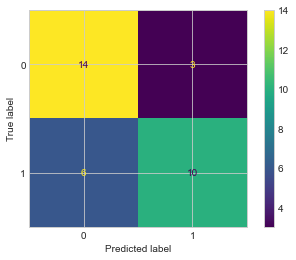

[17:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The confusion matrix at level 4 is: 
 [[17  3]
 [ 0 13]]
The accuracy score is: 0.9090909090909091
[17:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

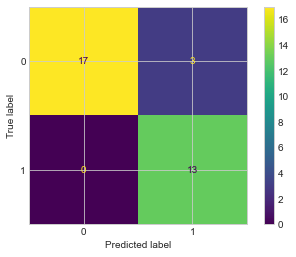

In [15]:
#XGB

def xgb(X_test, X_train, y_train, y_test, level):
    XGB_classifier = XGBClassifier(use_label_encoder = False)
    XGB_classifier.fit(X_train, y_train)
    y_pred = XGB_classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    score6 = accuracy_score(y_test, y_pred)
    print(f"The confusion matrix at level {level} is: \n {cm}")
    print(f"The accuracy score is: {score6}")
    scores = cross_val_score(XGB_classifier, X_train, y_train, cv=5)
    print(f"The cross validation scores for XGB are {scores}")

    print(f"The mean of the cross validation scores for XGB is {np.mean(cross_val_score(XGB_classifier, X_train, y_train, cv=10))}")

    y_pred = XGB_classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()


for (X_test, X_train, y_train, y_test, level) in data_list:
    xgb(X_test, X_train, y_train, y_test, level)